In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

In [20]:
# Parameters
S0, K, r, sigma, T = 100.0, 100.0, 0.05, 0.5, 1.0
N = 200_000

# Random draws (antithetic + CRN ready)
rng = np.random.default_rng(42)
Z = rng.standard_normal(N)
Z = np.concatenate([Z, -Z])
N = Z.size
W_T = np.sqrt(T) * Z
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * W_T)
payoffs = np.maximum(S_T - K, 0)
price_mc = np.exp(-r*T) * np.mean(payoffs)

# Analytical Black–Scholes
d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
d2 = d1 - sigma*np.sqrt(T)
Delta = norm.cdf(d1)
Vega = S0 * norm.pdf(d1) * np.sqrt(T)
Rho = K * T * np.exp(-r*T) * norm.cdf(d2)
Theta = - (S0 * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r*T) * norm.cdf(d2)

# Finite difference Greeks
eps_S, eps_sigma, eps_r, eps_T = 0.5, 0.01, 1e-4, 1e-4

In [21]:
def mc_price(S0_local=None, sigma_local=None, r_local=None, T_local=None):
    S0_l = S0 if S0_local is None else S0_local
    sigma_l = sigma if sigma_local is None else sigma_local
    r_l = r if r_local is None else r_local
    T_l = T if T_local is None else T_local
    Znorm = W_T / np.sqrt(T)
    W_T_new = np.sqrt(T_l) * Znorm
    S_T_local = S0_l * np.exp((r_l - 0.5*sigma_l**2) * T_l + sigma_l * W_T_new)
    return np.exp(-r_l*T_l) * np.mean(np.maximum(S_T_local - K, 0.0))

In [22]:
delta_fd = (mc_price(S0 + eps_S) - mc_price(S0 - eps_S)) / (2*eps_S)
vega_fd  = (mc_price(sigma_local=sigma + eps_sigma) - mc_price(sigma_local=sigma - eps_sigma)) / (2*eps_sigma)
rho_fd   = (mc_price(r_local=r + eps_r) - mc_price(r_local=r - eps_r)) / (2*eps_r)
theta_fd = (mc_price(T_local=T + eps_T) - mc_price(T_local=T - eps_T)) / (2*eps_T)

In [23]:
# Create outputs directory
from pathlib import Path

out_dir = Path("../outputs")            # parent of src -> project root / outputs
out_dir.mkdir(parents=True, exist_ok=True)

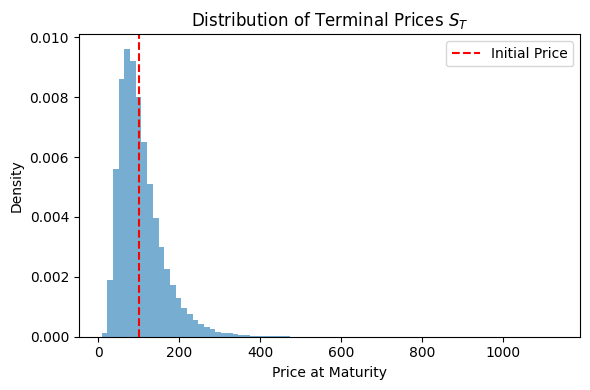

In [24]:
# ---- 1. Save sample histogram ----
plt.figure(figsize=(6,4))
plt.hist(S_T, bins=80, density=True, alpha=0.6)
plt.axvline(S0, color="red", linestyle="--", label="Initial Price")
plt.title("Distribution of Terminal Prices $S_T$")
plt.xlabel("Price at Maturity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / "price_distribution.png")

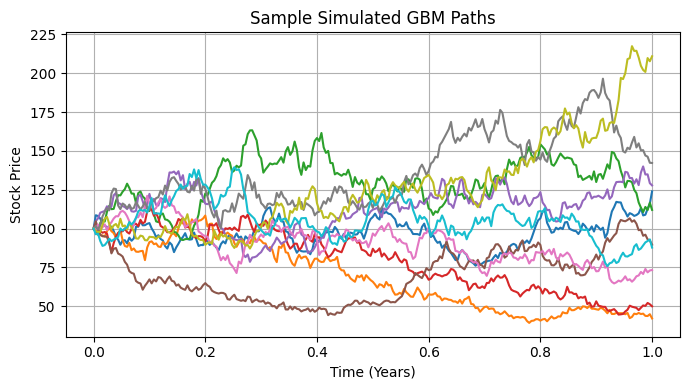

In [25]:
# ---- 2. Save sample paths ----
# regenerate 10 short paths for illustration
M = 250
dt = T / M
t = np.linspace(0, T, M+1)
Zpaths = rng.standard_normal((10, M))

# cumulative sums of increments (shape: (n_paths, M))
Wpaths_increments = np.cumsum(np.sqrt(dt) * Zpaths, axis=1)
# prepend zero column for t=0 so Wpaths has shape (n_paths, M+1) and lines up with t
Wpaths = np.concatenate([np.zeros((Zpaths.shape[0], 1)), Wpaths_increments], axis=1)

S_paths = S0 * np.exp((r - 0.5*sigma**2) * t + sigma * Wpaths)
plt.figure(figsize=(7,4))
for i in range(10):
    plt.plot(t, S_paths[i])
plt.title("Sample Simulated GBM Paths")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.tight_layout()
plt.savefig(out_dir / "sample_paths.png")

In [26]:
# ---- 3. Save summary to text ----
with open(out_dir / "greek_comparison.txt", "w") as f:
    f.write(f"Monte Carlo Price: {price_mc:.4f}\n\n")
    f.write("Analytic Greeks:\n")
    f.write(f"  Delta: {Delta:.6f}\n  Vega: {Vega:.6f}\n  Rho: {Rho:.6f}\n  Theta: {Theta:.6f}\n\n")
    f.write("Finite-Difference Greeks (MC):\n")
    f.write(f"  Delta: {delta_fd:.6f}\n  Vega: {vega_fd:.6f}\n  Rho: {rho_fd:.6f}\n  Theta: {theta_fd:.6f}\n")

In [27]:
print("Monte Carlo Price:", price_mc)
print("Analytic Greeks:", Delta, Vega, Rho, Theta)
print("FD Greeks:", delta_fd, vega_fd, rho_fd, theta_fd)
print("Results saved to outputs/")

Monte Carlo Price: 21.880696166292935
Analytic Greeks: 0.6368306511756191 37.52403469169379 41.89046090469506 -11.475531718158201
FD Greeks: 0.6378173998385215 37.837005309567395 41.89957242754616 11.554657896084564
Results saved to outputs/
